# Práctica: Exploración de pozos
El objetivo de este ejercicio es el de, a través de la exploración de una base de datos, determinar en qué pozos deben de enfocarse la atención.

$x = a + b*x$

In [9]:
%matplotlib inline
import pandas
import matplotlib.pyplot as plt

a = pandas.read_csv("params.csv")
len(a)

7321

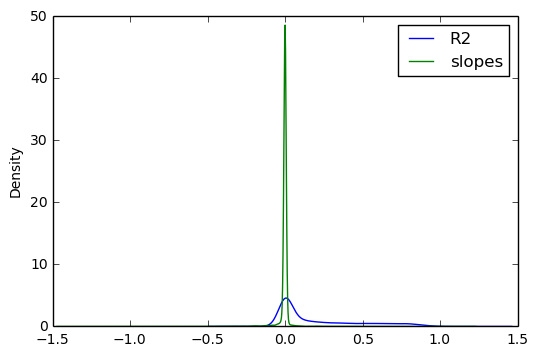

In [10]:
a.plot.density(); plt.show()